In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def denoise_bregman(img, weight, max_iters=10000, eps=0.001):
    rows, cols = img.shape
    weight = weight
    
    res = np.zeros([rows + 2, cols + 2])
    dx,dy,bx,by = res.copy(), res.copy(), res.copy(), res.copy()
    
    res[0, 1:-1] = img[1, :]
    res[1:-1, 0] = img[:, 1]
    res[-1, 1:-1] = img[-1, :]
    res[1:-1, -1] = img[:, -1]

    i = 0
    lam = 2 * weight
    rmse = np.inf
    norm = (weight + 4 * lam)
        
    while i < max_iters and rmse > eps:
        rmse = 0
        for r in range(1, rows + 1):
            for c in range(1, cols + 1):
                u_old = res[r, c]

                ux,uy = res[r, c + 1] - u_old,res[r + 1, c] - u_old

                var_out=(res[r + 1, c] + res[r - 1, c]+ res[r, c + 1]+ res[r, c - 1])
                d_var=dx[r, c - 1]- dx[r, c] + dy[r - 1, c]- dy[r, c]
                b_var=- bx[r, c - 1]+ bx[r, c]- by[r - 1, c,]+ by[r, c]
                u_new= (lam * (var_out+d_var+b_var) + weight * img[r - 1, c - 1]) / norm
                res[r, c] = u_new

                tx = u_new - u_old
                rmse += float(tx * tx)
                bxx = bx[r, c]
                byy = by[r, c]
                
                s = ux + bxx
                dxx = max(min(s - 1/lam, 1/lam), -1/lam)
                s = uy + byy
                dyy = max(min(s - 1/lam, 1/lam), -1/lam)
                
                dx[r, c] = dxx
                dy[r, c] = dyy
                bx[r, c] += ux - dxx
                by[r, c] += uy - dyy
        rmse = np.sqrt(rmse / (rows*cols))
        i += 1
    return res[1:-1, 1:-1]

In [3]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [4]:
def awgn(in_img, sigma):
    noise = sigma * np.random.randn(*in_img.shape)
    return in_img + noise

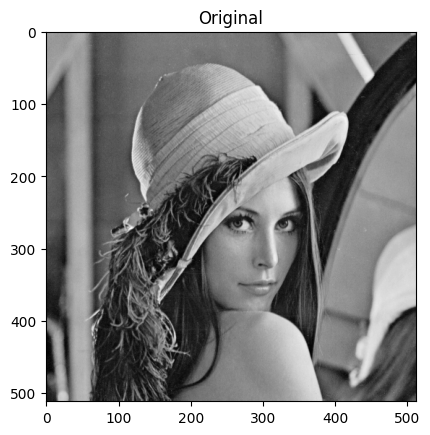

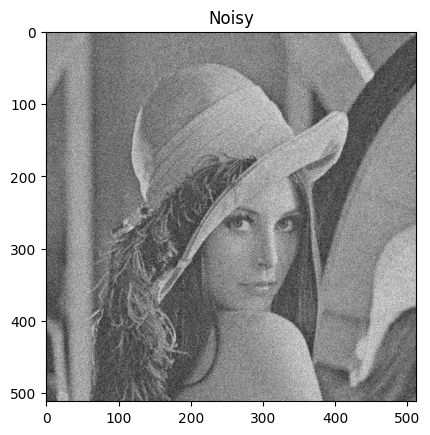

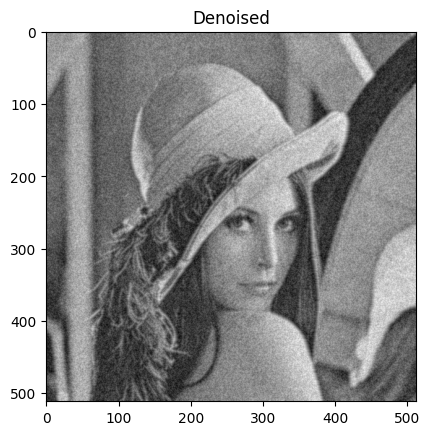

PSNR:  24.917369659578515


In [6]:
img_dir = "lena.png"
img = cv2.imread(img_dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_cp = img.copy() / 255

noisy_img = awgn(img_cp, 0.1)

denoised_img = denoise_bregman(noisy_img, weight=5)
denoised_img = (denoised_img - denoised_img.min())/(denoised_img.max() - denoised_img.min()) * 255

plt.imshow(img, cmap='gray')
plt.title("Original")
plt.show()

plt.imshow(noisy_img, cmap='gray')
plt.title("Noisy")
plt.show()

plt.imshow(denoised_img, cmap='gray')
plt.title("Denoised")
plt.show()

print("PSNR: ", cv2.PSNR(img.astype('float64'), denoised_img))